# 예측모델 만들기

## Preprocessing

### improt library

In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### 데이터 가져오기

In [0]:
data = pd.read_csv('gdrive/My Drive/공모전/Lpoint/데이터셋 만들기/lotte_drama.csv')
data.rename(columns = {'CLAC1_NM':'분류','CLAC2_NM':'중분류'},inplace = True)
data = pd.get_dummies(data,columns = ['분류','중분류'])
target = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score1.csv')
target2 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score2.csv')
dataset = pd.merge(data,target, how = 'inner', on=['LABEL']).set_index('LABEL')
dataset2 = pd.merge(data,target2, how = 'inner', on=['LABEL']).set_index('LABEL')

In [0]:
data2 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/데이터셋 만들기/mlotte_drama.csv')
data2.rename(columns = {'CLAC1_NM':'분류','CLAC2_NM':'중분류'},inplace = True)
data2 = pd.get_dummies(data2,columns = ['분류','중분류'])
target21 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score12.csv')
target22 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score22.csv')
testset = pd.merge(data2,target21, how = 'inner', on=['LABEL']).set_index('LABEL')
testset2 = pd.merge(data2,target22, how = 'inner', on=['LABEL']).set_index('LABEL')

In [5]:
dataset[['PD_BUY_AM','PD_BUY_CT','PD_SALES','BRA_SC','CLAC3_SC','SCORE']].corr('pearson')

,PD_BUY_AM,PD_BUY_CT,PD_SALES,BRA_SC,CLAC3_SC,SCORE
PD_BUY_AM,1.000000,-0.064173,0.061755,-0.054930,0.015493,0.038257
PD_BUY_CT,-0.064173,1.000000,0.807087,0.003129,0.077067,0.016302
PD_SALES,0.061755,0.807087,1.000000,0.012561,0.050767,0.014349
BRA_SC,-0.054930,0.003129,0.012561,1.000000,0.041518,0.032633
CLAC3_SC,0.015493,0.077067,0.050767,0.041518,1.000000,-0.064744
SCORE,0.038257,0.016302,0.014349,0.032633,-0.064744,1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f4fc197d0f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4fc197d0f0>)

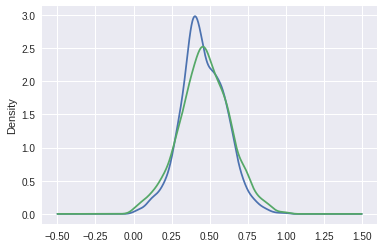

In [6]:
dataset['SCORE'].plot.density(), dataset2['SCORE2'].plot.density()

### 데이터 전처리

In [0]:
# bins = [dataset['SCORE'].quantile(i*0.25) for i in range(5)]
bins = [i*.25 for i in range(5)]
# labels = ['Fine','Good','Great','Perfect']
labels = range(4)
dataset['SCORE']=pd.cut(dataset['SCORE'], bins = bins, labels = labels)
dataset2['SCORE2']=pd.cut(dataset2['SCORE2'], bins = bins, labels = labels)
testset['SCORE']=pd.cut(testset['SCORE'], bins = bins, labels = labels)
testset2['SCORE2']=pd.cut(testset2['SCORE2'], bins = bins, labels = labels)

In [0]:
# dataset['SCORE'][dataset['SCORE'].isnull()] = 'Fine'
# dataset2['SCORE2'][dataset2['SCORE2'].isnull()] = 'Fine'
# testset['SCORE'][testset['SCORE'].isnull()] = 'Fine'
# testset2['SCORE2'][testset2['SCORE2'].isnull()] = 'Fine'
dataset['SCORE'][dataset['SCORE'].isnull()] = 0
dataset2['SCORE2'][dataset2['SCORE2'].isnull()] = 0
testset['SCORE'][testset['SCORE'].isnull()] = 0
testset2['SCORE2'][testset2['SCORE2'].isnull()] = 0

In [0]:
# trainset = dataset2[:-2735] 
# testset = testset[-2735:]
# # X_train, y_train = trainset.iloc[:,:-1], trainset['SCORE2']
# # X_test, y_test = testset.iloc[:,:-1], testset['SCORE2']
# trainset = dataset[:-2735] 
# testset = dataset[-2735:]
# X_train, y_train = trainset.iloc[:,:-1], trainset['SCORE']
# X_test, y_test = testset.iloc[:,:-1], testset['SCORE']
# X_train, y_train = dataset.iloc[:,:-1], dataset['SCORE']
# X_test, y_test = testset.iloc[:,:-1], testset['SCORE']
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [0]:
X, y = dataset.iloc[:,:-1], dataset['SCORE']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
from sklearn.preprocessing import StandardScaler

# Scale the variables to have 0 mean and unit variance
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [12]:
X_train.shape[0]

3325

## Models

In [0]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED)

# 클래스 정의
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
# Class to extend XGboost classifer

In [0]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### 튜닝한 파라미터 설정

In [0]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'bootstrap': True,
    'n_jobs': -1,
    'n_estimators': 1800,
     'warm_start': True, 
    'max_depth': 10,
    'min_samples_leaf': 4,
    'min_samples_split': 5,
    'max_features' : 'auto',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'bootstrap': False,
    'n_jobs': -1,
    'n_estimators':800,
    'max_features': 'sqrt',
    'max_depth': 20,
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 400,
    'learning_rate' : 0.05
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 1600,
    'max_features': 'auto',
    'max_depth': 80,
    'min_samples_leaf': 4,
    'min_samples_split': 5,
    'verbose': 0
}

### Train Models

In [0]:
# Create 4 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)

In [17]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,X_train, y_train, X_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,X_train, y_train, X_test) # Gradient Boost

print("Training is complete")

Training is complete


### 변수 중요도 확인

In [0]:
rf_feature = rf.feature_importances(X_train,y_train)
et_feature = et.feature_importances(X_train, y_train)
ada_feature = ada.feature_importances(X_train, y_train)
gb_feature = gb.feature_importances(X_train,y_train)

In [19]:
len(rf_feature),len(et_feature),len(ada_feature),len(gb_feature),len(dataset.columns.values)

(73, 73, 73, 73, 74)

In [0]:
cols = dataset.iloc[:,:-1].columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
#       'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [21]:
feature_dataframe.head()

,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features
0,0.032181,0.130025,0.077257,PD_BUY_AM
1,0.021380,0.025876,0.041797,PD_BUY_CT
2,0.022663,0.113005,0.059920,PD_SALES
3,0.024843,0.083258,0.038783,BRA_SC
4,0.030014,0.052760,0.031699,CLAC3_SC


In [22]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.sort_values(by=['mean'],ascending=False).head(7)

,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.032181,0.130025,0.077257,PD_BUY_AM,0.079821
2,0.022663,0.113005,0.059920,PD_SALES,0.065196
52,0.084157,0.033286,0.057333,중분류_메이크업,0.058258
3,0.024843,0.083258,0.038783,BRA_SC,0.048961
55,0.068573,0.024729,0.050556,중분류_보석,0.047953
4,0.030014,0.052760,0.031699,CLAC3_SC,0.038157
22,0.026525,0.037943,0.045790,Desktop,0.036753


In [23]:
feature_dataframe.sort_values(by=['Random Forest feature importances'],ascending=False).head(7)

,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.032181,0.130025,0.077257,PD_BUY_AM,0.079821
2,0.022663,0.113005,0.059920,PD_SALES,0.065196
52,0.084157,0.033286,0.057333,중분류_메이크업,0.058258
55,0.068573,0.024729,0.050556,중분류_보석,0.047953
22,0.026525,0.037943,0.045790,Desktop,0.036753
1,0.021380,0.025876,0.041797,PD_BUY_CT,0.029684
21,0.025267,0.025581,0.041527,NOT_SIGNED,0.030792


In [24]:
feature_dataframe.sort_values(by=['Gradient Boost feature importances'],ascending=False).head(7)

,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.032181,0.130025,0.077257,PD_BUY_AM,0.079821
2,0.022663,0.113005,0.059920,PD_SALES,0.065196
3,0.024843,0.083258,0.038783,BRA_SC,0.048961
4,0.030014,0.052760,0.031699,CLAC3_SC,0.038157
8,0.021748,0.041926,0.032653,F_40,0.032109
22,0.026525,0.037943,0.045790,Desktop,0.036753
23,0.023013,0.034877,0.039785,Mobile,0.032559


In [25]:
feature_dataframe.sort_values(by=['Extra Trees  feature importances'],ascending=False).head(7)

,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
52,0.084157,0.033286,0.057333,중분류_메이크업,0.058258
55,0.068573,0.024729,0.050556,중분류_보석,0.047953
0,0.032181,0.130025,0.077257,PD_BUY_AM,0.079821
4,0.030014,0.052760,0.031699,CLAC3_SC,0.038157
66,0.029786,0.004404,0.017755,중분류_여성화,0.017315
41,0.028592,0.004419,0.019024,분류_여성의류,0.017345
22,0.026525,0.037943,0.045790,Desktop,0.036753


### Output 결합

In [26]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,2.0,1.0
4,1.0,1.0,0.0,1.0


### XGBoost 파라미터 설정

### Train XGBoost

In [0]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

In [0]:
gbm = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='multi:softmax', 
                      n_estimators=1000,
                      max_depth=5, 
                      gamma=5).fit(x_train, y_train)
pred = gbm.predict(x_test)

In [0]:
svc = SVC(kernel='rbf', C = 10.0, gamma='scale').fit(x_train, y_train)
pred = svc.predict(x_test)

### 성능평가

#### Accuracy

In [33]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, pred)

print(f'Accuracy score: {accuracy}')

Accuracy score: 0.6105769230769231


#### confusion Matrix

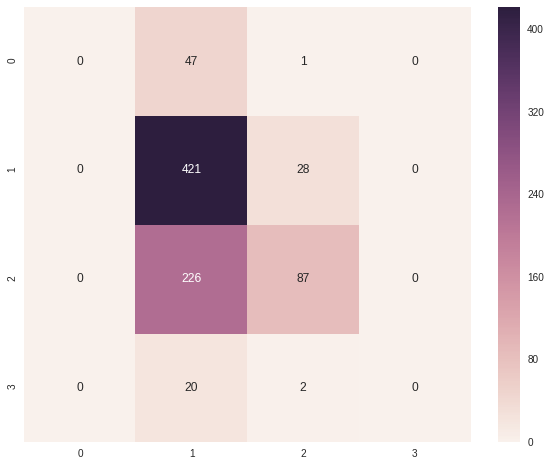

In [0]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,8))
cm = pd.DataFrame(confusion_matrix(y_test, pred))

sns.heatmap(cm, annot=True, fmt="d", xticklabels = labels, yticklabels = labels, annot_kws={"size": 12})

#### F1-score

In [0]:
from sklearn.metrics import f1_score
f1_score(y_test, pred, average = 'micro')

0.6105769230769231

In [0]:
f1_score(y_test, pred, average = 'weighted')

0.5425881203243135

In [0]:
f1_score(y_test, pred, average = None)

array([0.        , 0.72398968, 0.4037123 , 0.        ])

#### ROC curve & AUC

In [0]:
from sklearn.preprocessing import label_binarize
y_test1 = label_binarize(y_test, classes=[0, 1, 2, 3])
pred1 = label_binarize(pred, classes=[0, 1, 2, 3])

##### AUC score

In [0]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test1, pred1)

0.5488563955589718

In [0]:
roc_auc_score(y_test1, pred1,average='micro')

0.7403846153846154

In [0]:
roc_auc_score(y_test1, pred1,average = 'weighted')

0.5876283473440085

##### ROC curve

In [0]:
from sklearn.metrics import roc_curve, auc

n_classes = y_test1.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

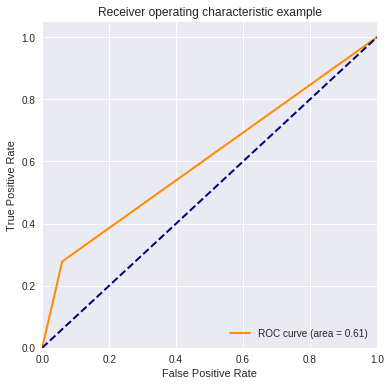

In [0]:
plt.figure(figsize = (6,6))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

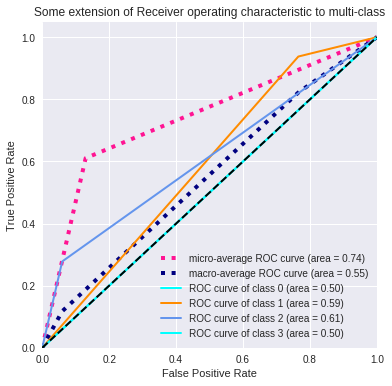

In [0]:
from scipy import interp
from itertools import cycle

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (6,6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()